# Extreme value theory

$$
\text{Mean} = \begin{cases}
\frac{\alpha x_m}{\alpha - 1} & \text{if } \alpha > 1 \
\text{undefined} & \text{if } \alpha \leq 1
\end{cases}
$$


$$
\text{Mean} = \frac{2.62 \cdot 100}{2.62 - 1} = \frac{262}{1.62} \approx 161.73
$$

## Create fake data

GPD parameters: shape (c)=-1.4340571927942665, location (loc)=-0.7871233160210814, scale (scale)=544.6791479220376
Probability of a non-zero observation in any given week: 1.0000
The 10-year return level (in weekly terms, adjusted for non-zero probability) is the price expected to be exceeded once every 10 years on a weekly basis: 578.98
The probability of exceeding the price level of 300 in any given week (adjusted for non-zero probability) is: 0.8065
The mean exceedance (expected average price above the threshold of 200) is: 305.94


/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_51404/3801393865.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2020-01-01', periods=size, freq='H')


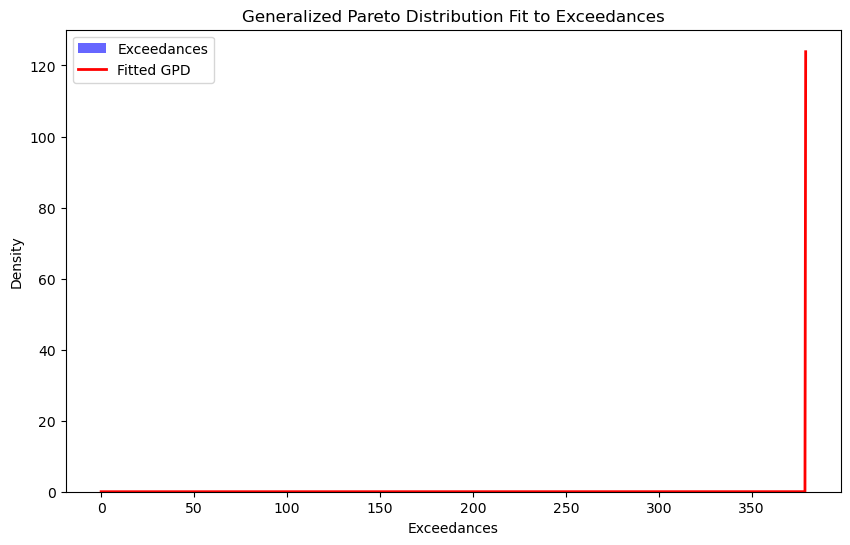

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import pandas as pd

# Generate synthetic data: most observations are 0, some percentage are Pareto-distributed
np.random.seed(42)
b = 2.62  # Shape parameter for Pareto distribution
size = 1000  # Total number of observations
p = 0.02  # Probability of non-zero observations

# Generate data: zeros and Pareto-distributed non-zero values
data = np.zeros(size)
non_zero_indices = np.random.choice(size, int(p * size), replace=False)
data[non_zero_indices] = (np.random.pareto(b, len(non_zero_indices)) + 1) * 100

# Create dates for the observations (multiple per day)
dates = pd.date_range(start='2020-01-01', periods=size, freq='H')

# Create a DataFrame with the data and dates
df = pd.DataFrame({'Date': dates, 'Price': data})

# Resample to weekly data, taking the max price observed each week
weekly_data = df.resample('W', on='Date').max()

# Define a high threshold
threshold = 200

# Extract non-zero data points and those that exceed the threshold
non_zero_prices = weekly_data[weekly_data['Price'] > 0]['Price']
exceedances = non_zero_prices[non_zero_prices > threshold] - threshold

# Fit the Generalized Pareto Distribution (GPD) to the exceedances
params = genpareto.fit(exceedances)
c, loc, scale = params

# Print the GPD parameters with explanations
print(f"GPD parameters: shape (c)={c}, location (loc)={loc}, scale (scale)={scale}")

# Calculate the probability of a non-zero observation
prob_non_zero = (weekly_data['Price'] > 0).mean()
print(f"Probability of a non-zero observation in any given week: {prob_non_zero:.4f}")

# Calculate the adjusted return level for a given return period
def adjusted_return_level(return_period, threshold, c, loc, scale, prob_non_zero):
    probability = 1 - (1 / return_period)
    return threshold + genpareto.ppf(probability, c, loc, scale)

# Example: Calculate the 10-year return level (adjusted for non-zero probability)
return_period = 10 * 52  # Convert years to weeks
r_level = adjusted_return_level(return_period, threshold, c, loc, scale, prob_non_zero)
print(f"The 10-year return level (in weekly terms, adjusted for non-zero probability) is the price expected to be exceeded once every 10 years on a weekly basis: {r_level:.2f}")

# Calculate the adjusted probability of exceedance for a given level
def adjusted_probability_of_exceedance(level, threshold, c, loc, scale, prob_non_zero):
    exceedance_value = level - threshold
    return prob_non_zero * (1 - genpareto.cdf(exceedance_value, c, loc, scale))

# Example: Probability of exceeding a level of 300 (adjusted for non-zero probability)
level = 300
prob_exceed = adjusted_probability_of_exceedance(level, threshold, c, loc, scale, prob_non_zero)
print(f"The probability of exceeding the price level of {level} in any given week (adjusted for non-zero probability) is: {prob_exceed:.4f}")

# Calculate the mean exceedance
def mean_exceedance(threshold, c, loc, scale):
    if c < 1:
        return threshold + (scale + c * threshold) / (1 - c)
    else:
        return float('inf')

mean_exc = mean_exceedance(threshold, c, loc, scale)
print(f"The mean exceedance (expected average price above the threshold of {threshold}) is: {mean_exc:.2f}")

# Plot the exceedances and the fitted GPD
x = np.linspace(0, np.max(exceedances), 1000)
pdf = genpareto.pdf(x, c, loc, scale)

plt.figure(figsize=(10, 6))
plt.hist(exceedances, bins=30, density=True, alpha=0.6, color='b', label='Exceedances')
plt.plot(x, pdf, 'r-', lw=2, label='Fitted GPD')
plt.xlabel('Exceedances')
plt.ylabel('Density')
plt.title('Generalized Pareto Distribution Fit to Exceedances')
plt.legend()
plt.show()